# Anomaly Detection with Autoencoder in PyTorch - TEST FOR WPAD PROJECT 

## Objective
The project focuses on detecting anomalies in audio data captured from water pumps. The primary approach involves:
- Extracting Mel Frequency Cepstral Coefficients (MFCCs) from audio files.
- Using the processed data for machine learning or deep learning models to identify anomalies based on significant deviations from normal patterns.

## Dataset Description
- **Anomaly Dataset**: Audio recordings labeled as anomalous.
- **Training Dataset**: Normal audio recordings for training the model.
- **Testing Dataset**: Normal audio recordings reserved for evaluation.

### Dataset Statistics:
- **Anomaly Files**: 456
- **Training Normal Files**: 2241
- **Testing Normal Files**: 400

## Preprocessing Steps
1. **Validation**:
   - Audio files are checked for integrity and compatibility.
   - Any unreadable or corrupt files are filtered out.

2. **Feature Extraction**:
   - **Normalization**: Audio signals are scaled to fall within a uniform range.
   - **Padding/Trimming**: Signals are adjusted to a fixed duration to maintain consistency.
   - **MFCC Extraction**:
     - Coefficients represent the spectral properties of the audio.
     - A 2D array is generated with dimensions `(time x coefficients)` for each audio file.

3. **Flattening**:
   - The MFCC arrays are flattened into 1D vectors for compatibility with dense neural networks.

### Resulting Dataset Shapes:
- **Anomaly Data**: `(456, 431, 13)` — time frames and 13 coefficients.
- **Flattened Anomaly Data**: `(456, 5603)` — single vector for each file.
- Similar structures exist for the training and testing datasets.

## Applications of MFCCs
- **Temporal Analysis**:
  - Temporal changes in the coefficients can indicate transitions or unusual behavior.
- **Pattern Recognition**:
  - Anomalies are highlighted through deviations in the MFCC pattern.


In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vuppalaadithyasairam/anomaly-detection-in-water-pump-using-audio-data")

print("Path to dataset files:", path)

100%|██████████| 736M/736M [00:25<00:00, 29.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/vuppalaadithyasairam/anomaly-detection-in-water-pump-using-audio-data/versions/1


In [ ]:
import os

# Define the base directory for the dataset
base_path = path + "/water pump audio for anomaly detection/"

# Define paths to each specific subset of the dataset
anomaly_path = os.path.join(base_path, "anomaly")          # Path for anomalous audio files
train_normal_path = os.path.join(base_path, "train-normal") # Path for normal training audio files
test_normal_path = os.path.join(base_path, "test-normal")   # Path for normal testing audio files

# Function to count the number of `.wav` files in a directory
def count_files_in_directory(directory):
    """
    Counts the number of `.wav` files in a given directory.

    Args:
        directory (str): Path to the directory to analyze.

    Returns:
        int: Number of `.wav` files in the directory.
    """
    return len([file for file in os.listdir(directory) if file.endswith('.wav')])

# Count the number of files in each subset
anomaly_count = count_files_in_directory(anomaly_path)
train_normal_count = count_files_in_directory(train_normal_path)
test_normal_count = count_files_in_directory(test_normal_path)

# Print the analysis
print("Preliminary Dataset Analysis:")
print(f"Number of files in 'anomaly': {anomaly_count}")
print(f"Number of files in 'train-normal': {train_normal_count}")
print(f"Number of files in 'test-normal': {test_normal_count}")

Preliminary Dataset Analysis:
Number of files in 'anomaly': 456
Number of files in 'train-normal': 2241
Number of files in 'test-normal': 400




## Analisi dei Dati MFCC Estratti e Normalizzati

### 1. **Tipologia di dati**:
   - **Numerici e strutturati:** Gli MFCC (Mel-Frequency Cepstral Coefficients) sono rappresentati come array bidimensionali, dove:
     - Una dimensione rappresenta i **frame temporali** (segmenti temporali dell'audio).
     - L'altra dimensione contiene i **coefficienti MFCC**, ciascuno dei quali rappresenta specifiche frequenze audio su una scala Mel.
   - Dopo la normalizzazione, i valori sono generalmente compressi nell'intervallo \([0, 1]\), facilitando l'utilizzo nei modelli di machine learning.

### 2. **Cosa rappresentano**:
   - **MFCC:** Catturano le informazioni spettrali dell'audio, trasformandole in una rappresentazione compatta e robusta rispetto alle variazioni non rilevanti (ad esempio il rumore di fondo o variazioni di ampiezza).
   - **Normalizzazione:** Elimina le differenze dovute all'ampiezza assoluta del segnale, garantendo una comparabilità uniforme tra diversi file audio.

### 3. **Come interpretarli**:
   - **Andamento temporale:** Ogni frame temporale contiene un set di coefficienti che descrive le frequenze principali in quel segmento temporale.
   - **Pattern ricorrenti:** Gli MFCC evidenziano caratteristiche che possono differenziare suoni normali da suoni anomali. Questo è particolarmente utile in applicazioni come il rilevamento di anomalie nei macchinari o nei sistemi audio.
   - **Applicazioni pratiche:** Questi coefficienti sono ampiamente utilizzati per il riconoscimento vocale, la classificazione audio e il rilevamento di guasti nei sistemi industriali.

### 4. **Utilità della normalizzazione**:
   - La normalizzazione standardizza i dati, rendendo il modello più robusto e meno sensibile a variazioni esterne come il volume del segnale.




In [ ]:
import librosa
import numpy as np

""" Questa è la fase in cui gli audio vengono trasformati in un formato
utilizzabile dal modello.

Il preprocessing include:
Normalizzazione: Adattare l'ampiezza del segnale audio a un intervallo standard.
Padding/Trimming: Assicurarsi che tutti gli audio abbiano la stessa durata, aggiungendo silenzio o tagliando parti in eccesso.
Estrazione MFCC: Calcolare i coefficienti cepstrali in scala Mel (MFCC), che rappresentano le caratteristiche chiave dell'audio.
"""

# Function to check if an audio file is valid
def check_audio_file(file_path):
    """
    Purpose:
        Ensures that each audio file is valid and can be successfully loaded.
        This avoids runtime errors during preprocessing and ensures the dataset's integrity.

    Args:
        file_path (str): Path to the audio file.

    Returns:
        bool: True if the file is valid, False otherwise.
    """
    try:
        # Attempt to load the file to check if it's readable
        librosa.load(file_path, sr=None)
        return True
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return False

# Validate files in each dataset
# Purpose: Filter out corrupt or unreadable files to ensure smooth preprocessing and model training.
print("Validating audio files...")

anomaly_valid = [file for file in os.listdir(anomaly_path) if file.endswith('.wav') and check_audio_file(os.path.join(anomaly_path, file))]
train_normal_valid = [file for file in os.listdir(train_normal_path) if file.endswith('.wav') and check_audio_file(os.path.join(train_normal_path, file))]
test_normal_valid = [file for file in os.listdir(test_normal_path) if file.endswith('.wav') and check_audio_file(os.path.join(test_normal_path, file))]

# Print counts of valid files
print(f"Valid files in 'anomaly': {len(anomaly_valid)}")
print(f"Valid files in 'train-normal': {len(train_normal_valid)}")
print(f"Valid files in 'test-normal': {len(test_normal_valid)}")

def normalize_mfcc(mfcc):
    """
    Normalizes MFCC features to the range [0, 1].

    Args:
        mfcc (np.ndarray): MFCC features of shape (time x features).

    Returns:
        np.ndarray: Normalized MFCC features.
    """
    return (mfcc - np.min(mfcc)) / (np.max(mfcc) - np.min(mfcc) + 1e-8)

def preprocess_audio(file_path, sr=22050, n_mfcc=13, max_duration=10):
    """
    Preprocesses an audio file to normalize, trim/pad to a fixed duration,
    and extract normalized Mel-Frequency Cepstral Coefficients (MFCC).

    Args:
        file_path (str): Path to the audio file.
        sr (int): Sampling rate to use when loading the audio (default: 22050 Hz).
        n_mfcc (int): Number of MFCC features to extract (default: 13).
        max_duration (int): Maximum duration of the audio in seconds (default: 5).

    Returns:
        np.ndarray: Transposed and normalized MFCC feature array (shape: time x features).
    """
    # Load the audio file
    signal, sr = librosa.load(file_path, sr=sr)

    # Normalize the audio signal
    signal = signal / np.max(np.abs(signal))

    # Pad or trim the signal to ensure uniform length
    max_length = sr * max_duration
    if len(signal) < max_length:
        signal = np.pad(signal, (0, max_length - len(signal)), 'constant')
    else:
        signal = signal[:max_length]

    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc)

    # Normalize the MFCC features
    normalized_mfcc = normalize_mfcc(mfcc)

    # Transpose to (time x features)
    return normalized_mfcc.T


# Function to preprocess a directory
def preprocess_directory(valid_files, directory):
    """
    Purpose:
        Apply the preprocessing function to all valid audio files in a directory
        to prepare data for training or evaluation.

    Args:
        valid_files (list): List of valid file names.
        directory (str): Path to the directory containing the files.

    Returns:
        np.ndarray: Array of preprocessed audio features.
    """
    data = []
    for file in valid_files:
        file_path = os.path.join(directory, file)
        mfcc = preprocess_audio(file_path)
        data.append(mfcc)
    return np.array(data)

# Preprocess all datasets
# Purpose: Convert raw audio files into structured numerical data for model input.
print("Preprocessing audio files...")

anomaly_data = preprocess_directory(anomaly_valid, anomaly_path)
train_normal_data = preprocess_directory(train_normal_valid, train_normal_path)
test_normal_data = preprocess_directory(test_normal_valid, test_normal_path)

# Print dimensions of preprocessed datasets
print(f"Anomaly Data Shape: {anomaly_data.shape}")
print(f"Train Normal Data Shape: {train_normal_data.shape}")
print(f"Test Normal Data Shape: {test_normal_data.shape}")

# Function to flatten data
def flatten_data(data):
    """
    Purpose:
        Flatten 2D MFCC feature arrays (time x features) into 1D arrays
        for compatibility with dense neural networks or simpler models.

    Args:
        data (np.ndarray): Array of MFCC features.

    Returns:
        np.ndarray: Flattened array for each audio file.
    """
    return np.array([x.flatten() for x in data])

# Flatten the data
# Purpose: Transform MFCC features to a format compatible with dense networks.

# Questa parte trasforma i dati MFCC, che sono matrici bidimensionali, in vettori unidimensionali.
# Molti modelli tra cui le reti neurali dense, richiedono input unidimensionali.
# 216 x 13 = 2808
anomaly_flattened = flatten_data(anomaly_data)
train_normal_flattened = flatten_data(train_normal_data)
test_normal_flattened = flatten_data(test_normal_data)


# Print flattened data shapes
print(f"Anomaly Flattened Shape: {anomaly_flattened.shape}")
print(f"Train Normal Flattened Shape: {train_normal_flattened.shape}")
print(f"Test Normal Flattened Shape: {test_normal_flattened.shape}")

Validating audio files...
Valid files in 'anomaly': 456
Valid files in 'train-normal': 2241
Valid files in 'test-normal': 400
Preprocessing audio files...
Anomaly Data Shape: (456, 431, 13)
Train Normal Data Shape: (2241, 431, 13)
Test Normal Data Shape: (400, 431, 13)
Anomaly Flattened Shape: (456, 5603)
Train Normal Flattened Shape: (2241, 5603)
Test Normal Flattened Shape: (400, 5603)




### 5. **Interpretazione dei grafici MFCC**:
   - **Colore:** Nei grafici degli MFCC, il colore rappresenta l'intensità del coefficiente in un determinato momento temporale e per una specifica frequenza:
     - Colori più chiari o caldi (come il giallo o il rosso) indicano un'intensità maggiore.
     - Colori più scuri o freddi (come il blu) indicano un'intensità minore.
   - **Bande:**
     - Le bande orizzontali rappresentano i **coefficienti MFCC** (dimensioni frequenziali), mentre l'asse verticale corrisponde al tempo.
     - Le bande più prominenti possono indicare specifiche frequenze dominanti nel segnale audio.
   - **Utilità pratica:**
     - Un segnale anomalo potrebbe presentare bande o pattern visivi significativamente diversi rispetto a un segnale normale.
     - Variazioni nei colori o nei pattern nel tempo possono indicare transizioni, anomalie o eventi significativi nel suono.



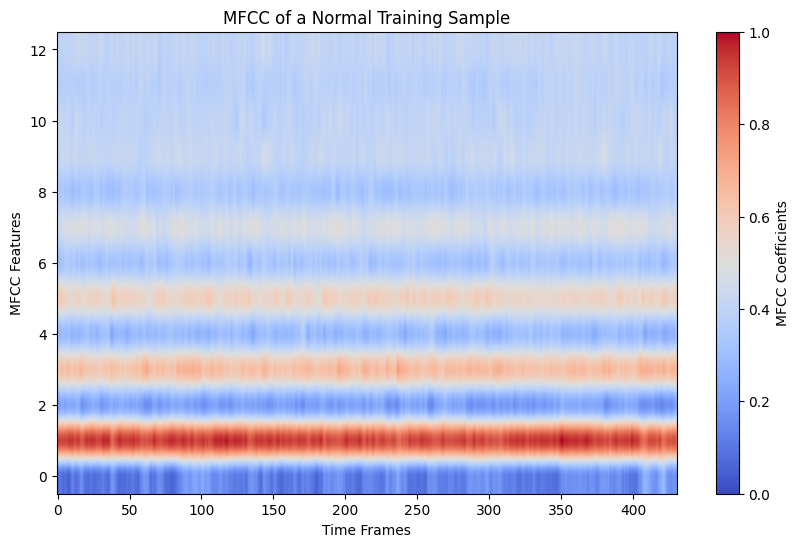

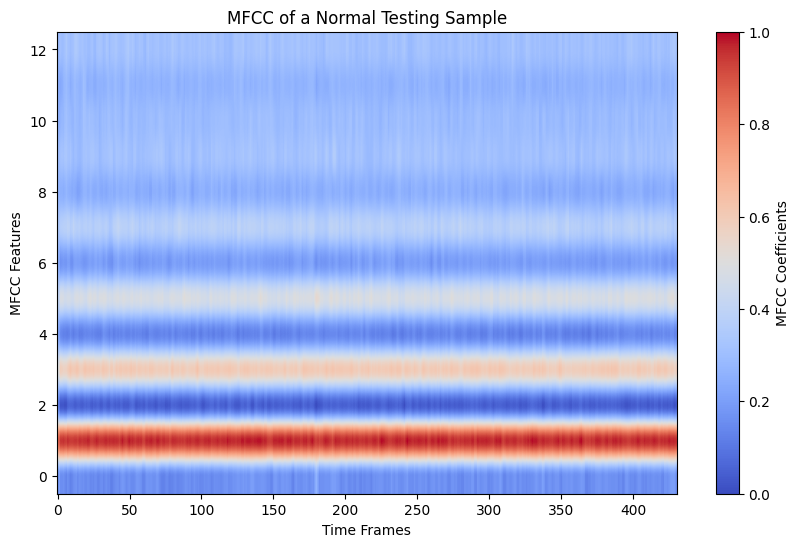

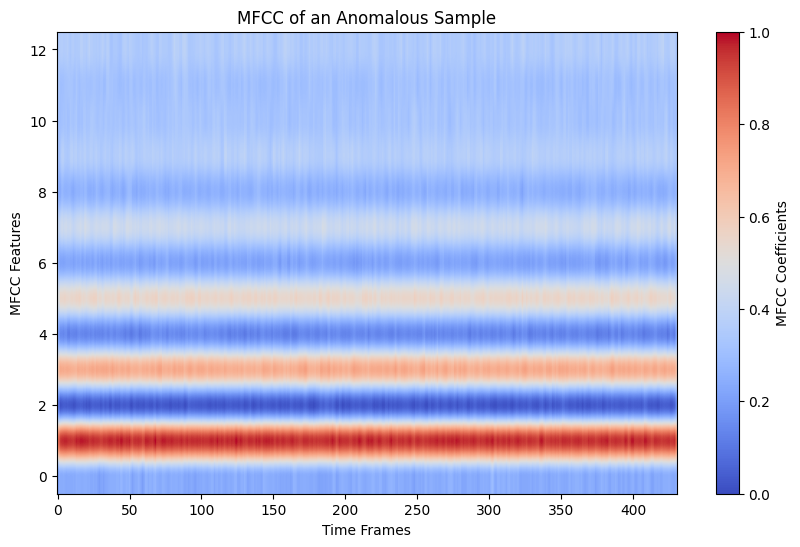

In [ ]:
import matplotlib.pyplot as plt
import random

# Visualizza un esempio di MFCC dal dataset pre-elaborato
def visualize_processed_mfcc(mfcc_data, title="Processed MFCC"):
    """
    Visualize the MFCC data that has already been preprocessed.

    Args:
        mfcc_data (np.ndarray): Preprocessed MFCC data (time x features).
        title (str): Title of the plot.
    """
    plt.figure(figsize=(10, 6))
    plt.imshow(mfcc_data.T, aspect='auto', origin='lower', cmap='coolwarm')
    plt.colorbar(label='MFCC Coefficients')
    plt.title(title)
    plt.xlabel('Time Frames')
    plt.ylabel('MFCC Features')
    plt.show()

# Visualizza un campione casuale da train_normal_data
random_index_train = random.randint(0, len(train_normal_data) - 1)
sample_mfcc_train = train_normal_data[random_index_train]
visualize_processed_mfcc(sample_mfcc_train, title="MFCC of a Normal Training Sample")

# Visualizza un campione casuale da test_normal_data
random_index_test = random.randint(0, len(test_normal_data) - 1)
sample_mfcc_test = test_normal_data[random_index_test]
visualize_processed_mfcc(sample_mfcc_test, title="MFCC of a Normal Testing Sample")

# Visualizza un campione casuale da anomaly_data
random_index_anomaly = random.randint(0, len(anomaly_data) - 1)
sample_mfcc_anomaly = anomaly_data[random_index_anomaly]
visualize_processed_mfcc(sample_mfcc_anomaly, title="MFCC of an Anomalous Sample")




## Struttura e Funzionamento dell'Autoencoder

### 1. **Cosa è un Autoencoder**:
Un autoencoder è una rete neurale progettata per apprendere una rappresentazione compressa (o codificata) di un set di dati, chiamata **spazio latente**, e quindi ricostruire i dati originali partendo da questa rappresentazione.

L'obiettivo principale è la riduzione dimensionale e la ricostruzione fedele dei dati, utile in compiti come il rilevamento delle anomalie.

---

### 2. **Struttura dell'Autoencoder**:
L'autoencoder descritto nel tuo codice ha due parti principali:

#### a. **Encoder**
   - Lo scopo dell'encoder è comprimere l'input in una rappresentazione più compatta nel **latente spazio**. Questo aiuta a identificare le caratteristiche principali del dato eliminando ridondanze.
   - Struttura:
     - **Layer 1:** Input dimensione \(N\), riduzione a 1024 nodi.
     - **Layer 2:** Ulteriore riduzione a 512 nodi.
     - **Layer 3:** Compressione al **latente spazio** di dimensione \(L\).
     - **Attivazione:** Funzioni ReLU sono utilizzate per introdurre non linearità e permettere l'apprendimento di rappresentazioni complesse.

#### b. **Decoder**
   - Il decoder prende la rappresentazione compatta generata dall'encoder e tenta di ricostruire l'input originale.
   - Struttura:
     - **Layer 1:** Espansione da \(L\) (latente spazio) a 512 nodi.
     - **Layer 2:** Espansione a 1024 nodi.
     - **Layer 3:** Espansione alla dimensione originale \(N\).
     - **Attivazione:** Una funzione sigmoid limita l'output tra \([0, 1]\), coerente con i dati normalizzati degli MFCC.

---

### 3. **Perché questa struttura?**

#### a. **Compressione Progressiva:**
   - L'encoder riduce gradualmente la dimensionalità per identificare le caratteristiche più significative del dato.
   - Il decoder segue una struttura speculare per ricostruire l'input originale, favorendo una rappresentazione bilanciata tra riduzione e ricostruzione.

#### b. **Latente Spazio:**
   - La dimensione ridotta consente di catturare solo le informazioni essenziali. Questo è utile per rilevare anomalie: se i dati compressi non rappresentano fedelmente un'anomalia, la ricostruzione mostrerà discrepanze.

#### c. **Non Linearità:**
   - L'uso delle funzioni ReLU aiuta a modellare relazioni complesse nei dati, aumentando la capacità di rappresentare i pattern nascosti.

---

### 4. **Funzionamento dell'Autoencoder**:

#### a. **Fase di Addestramento:**
   - L'input originale \(X\) viene passato attraverso l'encoder per ottenere una rappresentazione latente \(Z\).
   - Il decoder tenta di ricostruire \(\hat{X}\), minimizzando la perdita tra \(X\) e \(\hat{X}\).
   - La **loss function** usata è la Mean Squared Error (MSE), che misura l'errore di ricostruzione.

#### b. **Fase di Inference:**
   - Durante l'uso, si analizza quanto bene l'autoencoder ricostruisce l'input. Discrepanze elevate nella ricostruzione possono indicare anomalie.

---

### 5. **Applicazione al Dataset MFCC**:
   - **Input Dimensione:** Gli MFCC vengono appiattiti in vettori unidimensionali per essere compatibili con i layer densi.
   - **Latente Spazio:** La dimensione ridotta permette di catturare caratteristiche essenziali dell'audio.
   - **Rilevamento Anomalie:** I segnali audio normali verranno ricostruiti con alta fedeltà, mentre i segnali anomali mostreranno un errore di ricostruzione più alto.





In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Hyperparameters
input_dim = anomaly_flattened.shape[1]  # Dimensionalità dei dati input
latent_dim = 64  # Dimensione dello spazio latente
learning_rate = 0.001
epochs = 50
batch_size = 32

# Encoder
input_layer = Input(shape=(input_dim,))
encoder = Dense(128, activation='relu')(input_layer)
encoder = Dropout(0.2)(encoder)
encoder = Dense(64, activation='relu')(encoder)
latent = Dense(latent_dim, activation='relu', name="latent_space")(encoder)

# Decoder
decoder = Dense(64, activation='relu')(latent)
decoder = Dense(128, activation='relu')(decoder)
decoder_output = Dense(input_dim, activation='sigmoid')(decoder)

# Autoencoder Model
autoencoder = Model(inputs=input_layer, outputs=decoder_output)

# Compile the model
autoencoder.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

# Print the model summary
autoencoder.summary()

# Train the Autoencoder
history = autoencoder.fit(
    train_normal_flattened,  # Input
    train_normal_flattened,  # Output (ricostruzione)
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,  # 20% dei dati per la validazione
    shuffle=True
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 5603)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         717,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_space (Dense)                 │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 5603)                │         722,787 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,464,995 (5.59 MB)

 Trainable params: 1,464,995 (5.59 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0237 - val_loss: 0.0032
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 - val_l

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


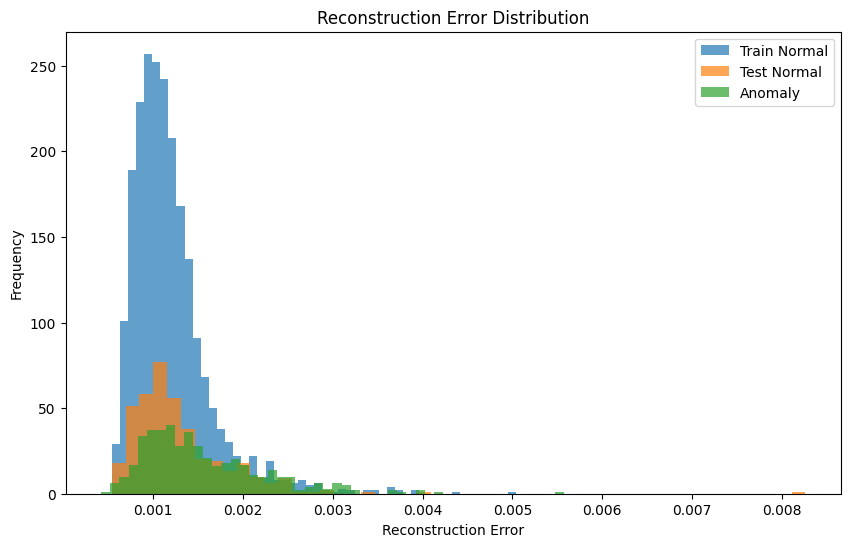

In [ ]:
import matplotlib.pyplot as plt

# Funzione per calcolare l'errore di ricostruzione
def reconstruction_error(original, reconstructed):
    return np.mean(np.square(original - reconstructed), axis=1)

# Ricostruisci i dati
train_reconstructed = autoencoder.predict(train_normal_flattened)
test_reconstructed = autoencoder.predict(test_normal_flattened)
anomaly_reconstructed = autoencoder.predict(anomaly_flattened)

# Calcola gli errori
train_errors = reconstruction_error(train_normal_flattened, train_reconstructed)
test_errors = reconstruction_error(test_normal_flattened, test_reconstructed)
anomaly_errors = reconstruction_error(anomaly_flattened, anomaly_reconstructed)

# Plot degli errori
plt.figure(figsize=(10, 6))
plt.hist(train_errors, bins=50, alpha=0.7, label='Train Normal')
plt.hist(test_errors, bins=50, alpha=0.7, label='Test Normal')
plt.hist(anomaly_errors, bins=50, alpha=0.7, label='Anomaly')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.title('Reconstruction Error Distribution')
plt.show()



## Visualizzazione dello Spazio Latente con t-SNE

### 1. **Motivazione**
La visualizzazione dei dati nello spazio latente aiuta a comprendere come il modello rappresenta internamente i dati e quanto bene separa le diverse classi (ad esempio, dati normali e anomalie). In questo caso, utilizziamo t-SNE per ridurre ulteriormente la dimensionalità dello spazio latente a due dimensioni, rendendo possibile una rappresentazione grafica.

---

### 2. **Dettaglio delle operazioni**

#### a. **Combinazione dei dati**:
- I dati latenti di diversi gruppi (ad esempio, training normale, testing normale e anomalie) vengono concatenati in un'unica matrice per facilitare l'applicazione di t-SNE.
- Viene anche creata una lista di etichette per identificare a quale gruppo appartiene ogni punto:
  - `0`: Train Normal
  - `1`: Test Normal
  - `2`: Anomaly

#### b. **Applicazione di t-SNE**:
- **t-SNE (t-Distributed Stochastic Neighbor Embedding)** è una tecnica di riduzione dimensionale che preserva le relazioni di vicinanza nei dati ad alta dimensione.
- In questo esempio:
  - Si riducono le dimensioni dei dati latenti a 2.
  - La casualità del metodo viene controllata con `random_state=42` per garantire riproducibilità.

#### c. **Visualizzazione con Matplotlib**:
- Viene creata una rappresentazione scatter plot dei dati latenti ridotti a 2 dimensioni.
- Ogni gruppo è rappresentato con un colore diverso:
  - **Blu**: Train Normal
  - **Verde**: Test Normal
  - **Rosso**: Anomaly
---

### 3. **Interpretazione del grafico**

- **Distribuzione dei punti:**
  - Punti appartenenti alla stessa classe (es. Train Normal) dovrebbero formare cluster distinti.
  - La separazione tra i cluster indica quanto bene il modello ha compresso e rappresentato le caratteristiche distintive dei dati.

- **Anomalie:**
  - Le anomalie (in rosso) dovrebbero idealmente essere separate dai punti normali, evidenziando che lo spazio latente riesce a catturare caratteristiche uniche dei dati anomali.

---

### 4. **Utilità del metodo**
- **Diagnostica del modello:** Permette di verificare se il modello distingue correttamente le classi.
- **Supporto decisionale:** Se i cluster non sono chiaramente separati, potrebbe essere necessario rivedere l'architettura o i parametri dell'autoencoder.
- **Riduzione dimensionale:** t-SNE è particolarmente utile per comprendere dati complessi in uno spazio di visualizzazione intuitivo.






71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


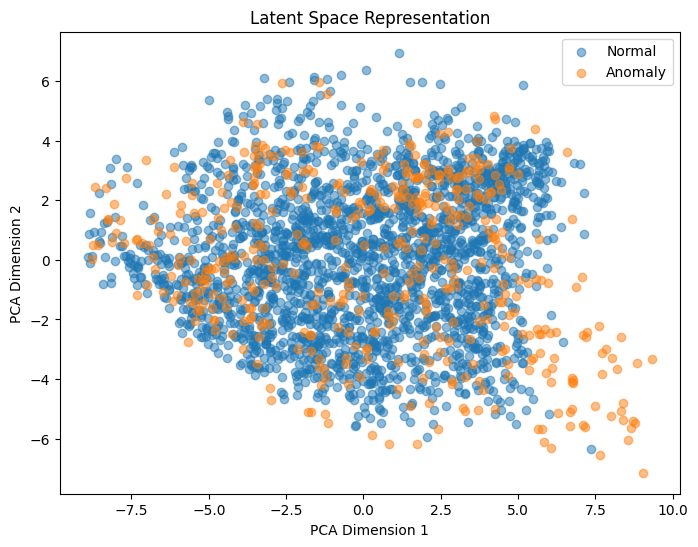

In [ ]:
# Modello Encoder
encoder_model = Model(inputs=input_layer, outputs=latent)

# Ottieni rappresentazioni latenti
train_latent = encoder_model.predict(train_normal_flattened)
test_latent = encoder_model.predict(test_normal_flattened)
anomaly_latent = encoder_model.predict(anomaly_flattened)

# Visualizzazione nello spazio latente (esempio con PCA o TSNE)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# PCA per ridurre la dimensione a 2
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(np.vstack([train_latent, anomaly_latent]))

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(latent_2d[:len(train_latent), 0], latent_2d[:len(train_latent), 1], alpha=0.5, label='Normal')
plt.scatter(latent_2d[len(train_latent):, 0], latent_2d[len(train_latent):, 1], alpha=0.5, label='Anomaly')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.title('Latent Space Representation')
plt.legend()
plt.show()
